# Betweenness Ranking of All Magazines

In [1]:
import os, string, warnings, glob, gensim, re, itertools, math, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import Counter

# Network libraries.
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph

# Ignore warnings.
warnings.simplefilter("ignore")

# Declare directory.
abs_dir = "/Users/williamquinn/Documents/DH/"

/Users/williamquinn/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Import Data

In [2]:
%%time

# Import model.
model = gensim.models.KeyedVectors.load_word2vec_format(abs_dir + 'Python/MJP/Word-Doc_Vectors/Models/mjp_w2v.txt')

# Import dataframe.
data = pd.read_csv(abs_dir + 'GitHub/DH2022_SemanticEmergence/Data_Outputs/new-vectors_CI.csv', 
                   sep = '\t')

data = data.query('(meta_type == "articles")')

data.head()

CPU times: user 1.91 s, sys: 63.4 ms, total: 1.98 s
Wall time: 2.03 s


,meta_mjp_id,meta_magazine,meta_type,meta_date,meta_year,vector,keyword,mean,count,std,ci_hi,ci_lo
0,4,The Little Review,articles,1914-12-01,1914,4_man,man,0.592083,41,0.023471,0.599268,0.584899
1,4,The Little Review,articles,1914-12-01,1914,4_woman,woman,0.724316,41,0.019561,0.730303,0.718328
2,4,The Little Review,articles,1914-12-01,1914,4_man,man,0.592083,41,0.023471,0.599268,0.584899
3,4,The Little Review,articles,1914-12-01,1914,4_woman,woman,0.724316,41,0.019561,0.730303,0.718328
4,6,The Little Review,articles,1914-12-01,1914,6_man,man,0.538298,41,0.018144,0.543852,0.532744


## Build Network Dataframe

In [3]:
%%time

edges = []

# Gather doc-to-doc similarities.
for idx, row in data.iterrows():
    source = row['vector']
    
    for sidx, srow in data.iterrows():
        target = srow['vector']
        weight = model.similarity(source, target)
        
        edges.append((source, target, weight))
        
edges = pd.DataFrame(edges, columns = ('source', 'target', 'weight'))

# Gather doc-to-keyword similarities & append.
keywords = data[['vector', 'keyword', 'mean']]
keywords = keywords.rename(columns = {'vector': 'source', 'keyword':'target', 'mean':'weight'})

edges = pd.concat([edges, keywords], ignore_index = True).drop_duplicates()

print (edges.shape)
edges.head()

(5431230, 3)
CPU times: user 31min 5s, sys: 15.7 s, total: 31min 21s
Wall time: 31min 34s


,source,target,weight
0,4_man,4_man,1.000000
1,4_man,4_woman,0.578643
4,4_man,6_man,0.602884
5,4_man,6_woman,0.408171
8,4_man,8_man,0.689452


### Filter Edges by Date

In [4]:
%%time

dates = data[['meta_date', 'vector']].rename(columns = {'vector': 'source', 'meta_date':'source_date'})
edges = pd.merge(edges, dates, how = 'inner').drop_duplicates()

dates = dates.rename(columns = {'source': 'target', 'source_date':'target_date'})
edges = pd.merge(edges, dates, how = 'inner').drop_duplicates()
    
edges = edges.query('source_date < target_date')

del dates

print (edges.shape)
edges.head()

(2697134, 5)
CPU times: user 13.1 s, sys: 1.89 s, total: 15 s
Wall time: 15.3 s


,source,target,weight,source_date,target_date
28,33_man,4_man,0.694262,1911-03-01,1914-12-01
30,33_woman,4_man,0.448905,1911-03-01,1914-12-01
32,39_man,4_man,0.664807,1911-03-01,1914-12-01
34,41_man,4_man,0.649506,1911-03-01,1914-12-01
36,43_man,4_man,0.725877,1911-03-01,1914-12-01


### Filter Edges by Weight

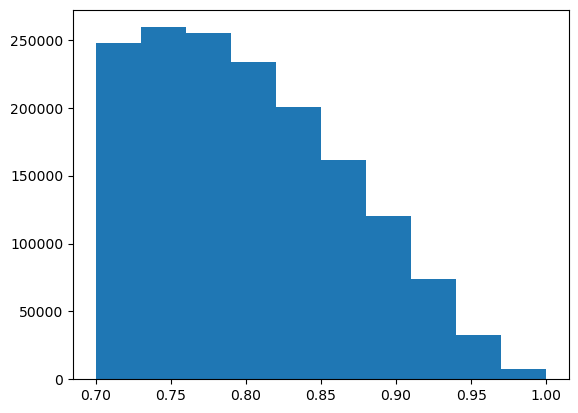

CPU times: user 535 ms, sys: 94.5 ms, total: 629 ms
Wall time: 683 ms


In [5]:
%%time

# Filter out weaker connections.
edges = edges.query('(source != target) & (weight >= 0.7) & (weight < 1.000000)')

plt.hist(edges['weight'], 10)
plt.show()

## Build Graph Object

In [6]:
%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(edges, 'source', 'target', ['weight'])

# Add nodes.
nodes = list( dict.fromkeys( edges['source'].values.tolist() + edges['target'].values.tolist() ))
nodes = pd.DataFrame(nodes, columns = ['source'])
G.add_nodes_from(nodes)

print (nx.info(G))

Graph with 2323 nodes and 1592999 edges
CPU times: user 5.9 s, sys: 201 ms, total: 6.1 s
Wall time: 6.12 s


### Assign Node Attributes

In [7]:
%%time

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree') 
print ('...degrees assigned')

# Find centrality measures.
betweenness_dict = nx.betweenness_centrality(G)
print ('...betweenness measured')
eigenvector_dict = nx.eigenvector_centrality(G)
print ('...eigenvector measured')
degree_cent_dict = nx.degree_centrality(G)
print ('...centrality measured')

# Assign centrality measures.
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(G, degree_cent_dict, 'degree_cent')

...degrees assigned
...betweenness measured
...eigenvector measured
...centrality measured
CPU times: user 22min 29s, sys: 1.93 s, total: 22min 31s
Wall time: 22min 34s


### Add Metadata as Node Attributes

In [8]:
%%time

# Assign node metadata.
for c in data.columns:
    c_dict = {}
    col_name = str(c).replace('meta_', '')
    
    for r in data.itertuples():    
        c_dict[ r.vector ] = getattr(r, c)
        
        nx.set_node_attributes(G, c_dict, col_name)

CPU times: user 49 s, sys: 54.2 ms, total: 49 s
Wall time: 49.1 s


## Centrality Measures

In [9]:

# Construct dataframe from list of dictionaries.
centrality = [betweenness_dict, eigenvector_dict, degree_cent_dict]

centrality = {k: [d[k] for d in centrality] for k in centrality[0]}

centrality = pd.DataFrame(centrality.items(), columns = ['source', 'centrality'])

centrality[['betweenness', 
            'eigenvector', 
            'degree_cent']] = pd.DataFrame(centrality['centrality'].tolist(), index = centrality.index)

centrality = centrality.drop(columns = ['centrality'])

# Join with degree info.
sorted_degree = sorted( dict( G.degree(G.nodes()) ).items(), key = itemgetter(1), reverse = True)
sorted_degree_df = pd.DataFrame(sorted_degree, columns = ['source', 'degree'])

centrality = centrality.merge(sorted_degree_df, on = 'source', how = 'inner')

centrality.describe()

,betweenness,eigenvector,degree_cent,degree
count,2323.000000,2.323000e+03,2323.000000,2323.000000
mean,0.000184,1.914071e-02,0.590655,1371.501507
std,0.000197,8.008657e-03,0.250732,582.199573
min,0.000000,7.846339e-25,0.000000,0.000000
25%,0.000032,1.468461e-02,0.440784,1023.500000
50%,0.000129,2.278941e-02,0.690353,1603.000000
75%,0.000276,2.525565e-02,0.787037,1827.500000
max,0.002263,2.713262e-02,0.889750,2066.000000


### Betweenness Ranking

In [10]:
%%time

# Rank betweenness.
betweenness_ranking = centrality.sort_values(by = ['betweenness'], ascending = False).reset_index()
betweenness_ranking['rank'] = betweenness_ranking.index + 1

betweenness_ranking

CPU times: user 4.12 ms, sys: 2.03 ms, total: 6.15 ms
Wall time: 4.7 ms


,index,source,betweenness,eigenvector,degree_cent,degree,rank
0,673,3192_man,0.002263,2.563807e-02,0.805340,1870,1
1,735,4981_egoist,0.001831,4.426356e-03,0.145995,339,2
2,813,7883_man,0.001818,1.895638e-02,0.567614,1318,3
3,2173,7605_egoist,0.001646,3.147002e-03,0.115848,269,4
4,1130,2785_man,0.001534,2.143819e-02,0.640827,1488,5
...,...,...,...,...,...,...,...
2318,2286,6345_man,0.000000,3.942237e-06,0.000861,2,2319
2319,2281,4183_man,0.000000,1.403982e-04,0.004307,10,2320
2320,2263,446_woman,0.000000,7.498946e-05,0.002153,5,2321
2321,2150,3623_woman,0.000000,6.778159e-05,0.002153,5,2322


### Filter edges where top 50 betweenness ranks appear.

In [14]:
betweenness_subset = betweenness_ranking.query('rank <= 50').sort_values(by = ['degree'], ascending = True)

betweenness_subset.head()

,index,source,betweenness,eigenvector,degree_cent,degree,rank
28,860,5887_egoism,0.000798,0.002032,0.078381,182,29
27,858,5517_egoism,0.000819,0.002032,0.078811,183,28
7,857,4344_egoist,0.001105,0.002952,0.105082,244,8
3,2173,7605_egoist,0.001646,0.003147,0.115848,269,4
1,735,4981_egoist,0.001831,0.004426,0.145995,339,2


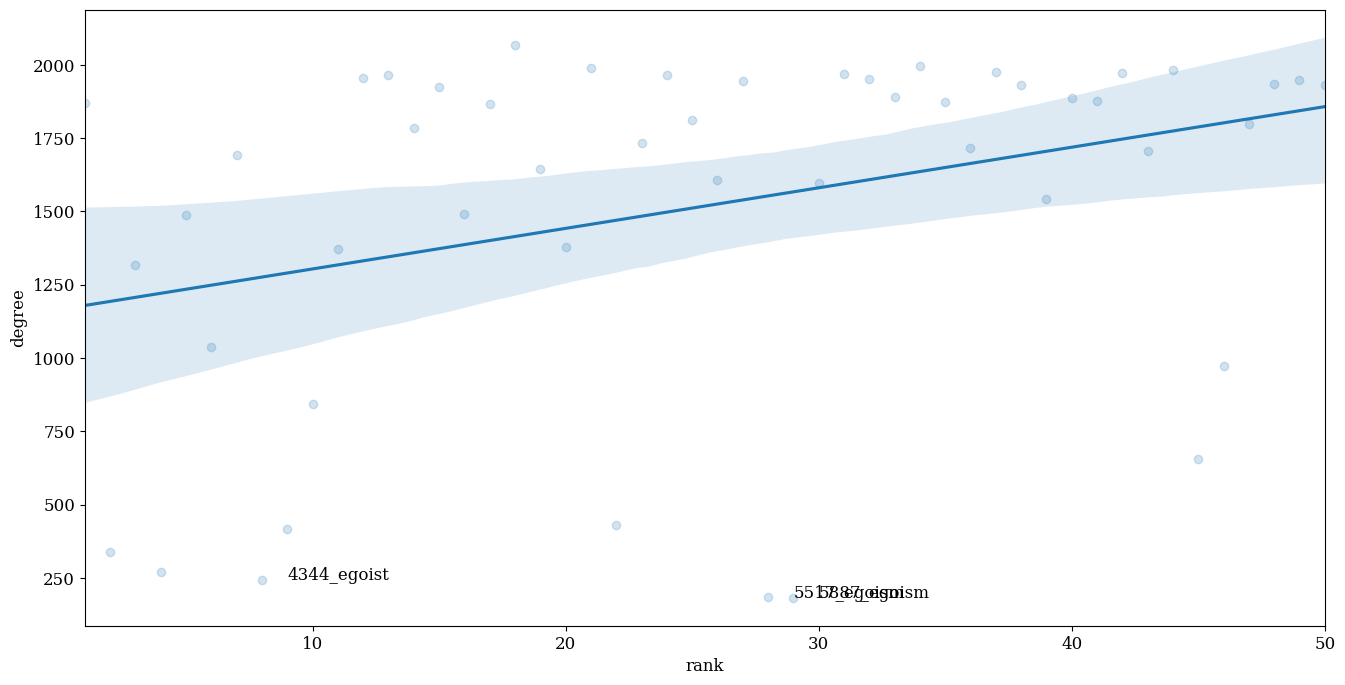

CPU times: user 347 ms, sys: 46.3 ms, total: 393 ms
Wall time: 395 ms


In [16]:
%%time

font = {'family': 'serif', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
plt.figure(figsize = (16, 8))

ax = sns.regplot(data = betweenness_subset, x = 'rank', y = 'degree',
                 scatter_kws = {'alpha': 0.2})

# label points on the plot only if they are higher than the mean
for x, y, z in zip(between_sub['rank'], between_sub['degree'], between_sub['source']):
    if x < 200 and y < 250:
        plt.text(x = x + 1, # x-coordinate position of data label
                 y = y,
                 s = z, # data label
                 color = 'black') # set colour of line
        
plt.show()

## Betweenness Network

In [22]:
%%time

subset_sources = betweenness_subset['source'].values

subset_nodes = [n for n,v in G.nodes(data=True) if v['source'].isin(subset_sources)]

H = G.subgraph(selected_nodes)

KeyError: 'source'